# VQ-VAE presentation (Ágora)

Ágora session: June 24, 2025

## Brief introduction

### Model parts

Given inputs $\mathbf{x} \in \mathbb{R}^n$, let the encoder output be denoted as

$$
z_e(\mathbf{x}) = E(\mathbf{x}) \in \mathbb{R}^D.
$$

Define the codebook as a set of vectors (embeddings):

$$
\{\mathbf{e}_i\}_{i=1}^K, \quad \mathbf{e}_i \in \mathbb{R}^D.
$$

Map the continuous encoder output to the dictionary words:

$$
k^*(\mathbf{x})
= \arg \min_{i=1,\ldots,K} \left|\left|z_e(\mathbf{x}) - \mathbf{e}_i\right|\right|_2^2, \quad z_q(x) = \mathbf{e}_{k^*(\mathbf{x})}.
$$

Given this quantized input, the decoder reconstruct the sample back to its original form:

$$
\hat{\mathbf{x}} = D\left(z_q(\mathbf{x})\right) \in \mathbb{R}^n.
$$

Note, in the VQ-VAE paper $\mathrm{sg}[\cdot]$ denotes the operation by which we forward pass identity and backward pass zero gradient.

### Loss function (per example)

For a single input $\mathbf{x}$:

$$
\mathcal{L}(\mathbf{x}) =
\underbrace{\left|\left|\mathbf{x}-\hat{\mathbf{x}}\right|\right|_2^2}_{\text{reconstruction}}
+ \underbrace{\left|\left|\mathrm{sg}\left[z_e(\mathbf{x})\right] - e_{k^*}\right|\right|_2^2}_{\text{codebook}}
+ \underbrace{\beta\left|\left|z_e(\mathbf{x}) - \mathrm{sg}\left[e_{k^*}\right]\right|\right|_2^2}_{\text{commitment}}
$$

with $\beta > 0$ being a hyperparameter. The VQ-VAE authors empirically settled on $\beta = 0.25$.

#### EMA codebook update

In practice, we usually employ an EMA codebook update for the codebook loss.

It is possible to see the ideal update for this term as the batch average of all encoder outputs mapped to $\mathbf{e}_i$. Suppose in a given batch the encoder output closes to a given embeddings are

$$
\{\mathbf{z}_{i,1}, \mathbf{z}_{i,2}, \ldots, \mathbf{z}_{i, n_i}\},
$$

then the optimal update is just

$$
\mathbf{e}_i = \frac{1}{n_i} \sum_{j=1}^{n_i} \mathbf{z}_{i,j}.
$$

But... this is rather impractical (requires keeping sums across entire dataset).

Therefore we employ EMA. Here use $t$ to represent a given minibatch; $n_i^{(t)}$ to signal the number of assignments to $\mathbf{e}_i$; $\{\mathbf{z}_{i,j}^(t)\}$ are the corresponding encoder outputs; and $0 < \gamma < 1$ is the decay factor.

We begin by accumulating counts:

$$
N_i^{(t)}
= \gamma N_i^{(t-1)} + (1-\gamma) n_i^{(t)},
$$

then sums:

$$
m_i^{(t)} = \gamma m_i^{(t-1)} + (1-\gamma) \sum_{j=1}^{n_i^{(t)}} \mathbf{z}_{i,j}^{(t)}.
$$

Now we recompute the codebook vector:

$$
\mathbf{e}_i^{(t)} =
\frac{m_i^{(t)}}{N_i^{(t)}}.
$$

The authors used $\gamma = 0.99$. By being close to $1$, this compels $N_i$ and $m_i$ to have long memory, effectively approx. the full dataset mean in an online manner.

## Code

Loading necessary libraries and setting seed for reproducibility.

In [1]:
import random

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

# set seed for all modules
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Fetching, loading and preparing data.

In [2]:
transform_common = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

datasets_config = {
    "MNIST": dict(
        cls=datasets.MNIST,
        args=dict(
            root="./data/mnist", train=True, download=True,
            transform=transforms.Compose([transforms.Grayscale(3), transforms.ToTensor(),
                                          transforms.Normalize((0.5,)*3,(0.5,)*3)])),
        test_args=dict(
            root="./data/mnist", train=False, download=True,
            transform=transforms.Compose([transforms.Grayscale(3), transforms.ToTensor(),
                                          transforms.Normalize((0.5,)*3,(0.5,)*3)])),
        batch_size=128
    ),
    "CIFAR10": dict(
        cls=datasets.CIFAR10,
        args=dict(
            root="./data/cifar10", train=True, download=True, transform=transform_common),
            test_args=dict(root="./data/cifar10", train=False, download=True, transform=transform_common),
        batch_size=128
    ),
    #"CelebA": dict(
    #    cls=datasets.CelebA,
    #    args=dict(root="./data/celeba", split="all", target_type="attr", download=False,
    #              transform=transforms.Compose([transforms.CenterCrop(178), transforms.Resize(64), 
    #                                            transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])),
    #    test_args=None,
    #    batch_size=64
    #)
}


### MNIST VQ-VAE

In [3]:
class EncoderMNIST(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, z_dim, 4, 2, 1)
        )

    def forward(self, x): 
        return self.conv(x)

class DecoderMNIST(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.conv(x)

### CIFAR10 VQ-VAE

In [4]:
class EncoderCIFAR(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, z_dim, 3, 1, 1)
        )

    def forward(self, x):
        return self.conv(x)

class DecoderCIFAR(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(z_dim, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.conv(x)

### Vector quantizer (with EMA)

In [5]:
class VectorQuantizerEMA(nn.Module):
    def __init__(
            self, num_embeddings, embedding_dim, commitment_cost,
            decay=0.99, eps=1e-5
        ):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        self.embedding.weight.data.normal_(0, 1)
        self.register_buffer("ema_cluster_size", torch.zeros(num_embeddings))
        self.ema_w = nn.Parameter(self.embedding.weight.data.clone())

        self.decay, self.eps, self.commitment_cost = decay, eps, commitment_cost

    def forward(self, inputs):
        shape = inputs.shape
        flat = inputs.permute(0,2,3,1).reshape(-1, shape[1])

        dist = (flat**2).sum(1, keepdim=True) \
            + (self.embedding.weight**2).sum(1) - 2*flat @ self.embedding.weight.t()
        idx = dist.argmin(1)
        one_hot = F.one_hot(idx, self.embedding.num_embeddings).type(flat.dtype)

        quant = one_hot @ self.embedding.weight
        quant = quant.view(shape[0], shape[2], shape[3], shape[1]).permute(0,3,1,2)

        if self.training:
            n = one_hot.sum(0)
            self.ema_cluster_size = self.ema_cluster_size * self.decay + (1-self.decay)*n
            dw = one_hot.t() @ flat

            self.ema_w = nn.Parameter(self.ema_w * self.decay + (1-self.decay)*dw)
            cluster_size = ((self.ema_cluster_size + self.eps) / 
                            (self.ema_cluster_size.sum() + self.num_embeddings * self.eps) *
                            self.ema_cluster_size.sum())
            self.embedding.weight.data = self.ema_w / cluster_size.unsqueeze(1)

        e_loss = F.mse_loss(quant.detach(), inputs)
        q_loss = F.mse_loss(quant, inputs.detach())

        loss = q_loss + self.commitment_cost * e_loss
        
        quant = inputs + (quant - inputs).detach()
        avg_probs = one_hot.mean(0)
        perp = torch.exp(- (avg_probs * torch.log(avg_probs + 1e-10)).sum())

        return quant, loss, perp

### Full model

In [6]:
class VQVAE(nn.Module):
    def __init__(self, dataset):
        super().__init__()

        if dataset=="MNIST":
            z_dim, n_e = 32, 128
            self.encoder = EncoderMNIST(z_dim)
            self.decoder = DecoderMNIST(z_dim)

        elif dataset=="CIFAR10":
            z_dim, n_e = 64, 512
            self.encoder = EncoderCIFAR(z_dim)
            self.decoder = DecoderCIFAR(z_dim)
        #else:
        #    z_dim, n_e = 128, 512
        #    self.encoder = EncoderCelebA(z_dim)
        #    self.decoder = DecoderCelebA(z_dim)

        self.pre_vq = nn.Conv2d(z_dim, z_dim, 1)
        self.vq = VectorQuantizerEMA(n_e, z_dim, commitment_cost=0.25)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq(z)
        q, vq_loss, perp = self.vq(z)
        
        return self.decoder(q), vq_loss, perp


### Additional utilities

Helper for early stopping.

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta

        self.best_loss = float("inf")
        self.wait = 0
        
    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0
            return False
        else:
            self.wait += 1
            return self.wait >= self.patience

Helpers for model saving, loading.

In [8]:
def save_checkpoint(model, optimizer, epoch, path):
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch
        },
        path
    )


def load_checkpoint(model, optimizer, path):
    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    
    return ckpt["epoch"]

Training and evaluation functions.

In [9]:
def train_vqvae(model, train_loader, val_loader, n_epochs, lr, patience, save_path):

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    recon_loss_fn = nn.MSELoss()
    early_stop = EarlyStopping(patience)

    best_val = float("inf")

    for epoch in range(1, n_epochs+1):

        model.train()

        train_loss = 0

        for x, _ in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            x = x.to(device)

            optimizer.zero_grad()

            x_recon, vq_loss, _ = model(x)

            loss = recon_loss_fn(x_recon, x) + vq_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_recon, vq_loss, _ = model(x)
                val_loss += \
                    (recon_loss_fn(x_recon, x) + vq_loss).item() * x.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch:03d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            save_checkpoint(model, optimizer, epoch, save_path)

        if early_stop.step(val_loss):
            print("Early stopping.")
            break

    load_checkpoint(model, optimizer, save_path)

    return model


def evaluate(model, test_loader):

    model.eval()

    recon_loss_fn = nn.MSELoss()
    total = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)

            x_recon, vq_loss, _ = model(x)

            total += \
                (recon_loss_fn(x_recon, x) + vq_loss).item() * x.size(0)

    avg = total / len(test_loader.dataset)
    print(f"Test Loss: {avg:.4f}")

Plotting reconstructions and originals side by side.

In [10]:
def visualize_reconstructions(model, data_loader, n=8):

    model.eval()

    batch = next(iter(data_loader))[0][:n].to(device)

    with torch.no_grad():
        recon, _, _ = model(batch)
    batch, recon = batch.cpu(), recon.cpu()

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        img = batch[i].permute(1,2,0) * 0.5 + 0.5
        axes[0,i].imshow(img.clip(0,1))
        axes[0,i].axis("off")

        img_r = recon[i].permute(1,2,0) * 0.5 + 0.5
        axes[1,i].imshow(img_r.clip(0,1))
        axes[1,i].axis("off")
        
    plt.show()

### Driver code (MNIST)

Training Epoch 1: 100%|██████████| 461/461 [00:02<00:00, 181.90it/s]


Epoch 001 | Train: 2.2865 | Val: 4.2516


Training Epoch 2: 100%|██████████| 461/461 [00:02<00:00, 197.49it/s]


Epoch 002 | Train: 4.9780 | Val: 6.0541


Training Epoch 3: 100%|██████████| 461/461 [00:02<00:00, 213.25it/s]


Epoch 003 | Train: 0.6221 | Val: 0.1366


Training Epoch 4: 100%|██████████| 461/461 [00:02<00:00, 215.62it/s]


Epoch 004 | Train: 0.1141 | Val: 0.0830


Training Epoch 5: 100%|██████████| 461/461 [00:02<00:00, 211.10it/s]


Epoch 005 | Train: 0.0701 | Val: 0.0598


Training Epoch 6: 100%|██████████| 461/461 [00:02<00:00, 217.30it/s]


Epoch 006 | Train: 0.0553 | Val: 0.0515


Training Epoch 7: 100%|██████████| 461/461 [00:02<00:00, 219.73it/s]


Epoch 007 | Train: 0.0492 | Val: 0.0471


Training Epoch 8: 100%|██████████| 461/461 [00:02<00:00, 209.22it/s]


Epoch 008 | Train: 0.0459 | Val: 0.0446


Training Epoch 9: 100%|██████████| 461/461 [00:02<00:00, 222.19it/s]


Epoch 009 | Train: 0.0446 | Val: 0.0446


Training Epoch 10: 100%|██████████| 461/461 [00:02<00:00, 218.26it/s]


Epoch 010 | Train: 0.0448 | Val: 0.0452


Training Epoch 11: 100%|██████████| 461/461 [00:02<00:00, 218.87it/s]


Epoch 011 | Train: 0.0455 | Val: 0.0459


Training Epoch 12: 100%|██████████| 461/461 [00:02<00:00, 208.73it/s]


Epoch 012 | Train: 0.0466 | Val: 0.0471


Training Epoch 13: 100%|██████████| 461/461 [00:02<00:00, 210.29it/s]


Epoch 013 | Train: 0.0478 | Val: 0.0486


Training Epoch 14: 100%|██████████| 461/461 [00:02<00:00, 214.59it/s]


Epoch 014 | Train: 0.0491 | Val: 0.0494


Training Epoch 15: 100%|██████████| 461/461 [00:02<00:00, 215.62it/s]


Epoch 015 | Train: 0.0500 | Val: 0.0504


Training Epoch 16: 100%|██████████| 461/461 [00:02<00:00, 222.77it/s]


Epoch 016 | Train: 0.0507 | Val: 0.0509


Training Epoch 17: 100%|██████████| 461/461 [00:02<00:00, 211.11it/s]


Epoch 017 | Train: 0.0511 | Val: 0.0514


Training Epoch 18: 100%|██████████| 461/461 [00:02<00:00, 216.75it/s]


Epoch 018 | Train: 0.0514 | Val: 0.0517


Training Epoch 19: 100%|██████████| 461/461 [00:02<00:00, 217.36it/s]


Epoch 019 | Train: 0.0516 | Val: 0.0515


Training Epoch 20: 100%|██████████| 461/461 [00:02<00:00, 216.72it/s]


Epoch 020 | Train: 0.0516 | Val: 0.0516


Training Epoch 21: 100%|██████████| 461/461 [00:02<00:00, 217.16it/s]


Epoch 021 | Train: 0.0517 | Val: 0.0516


Training Epoch 22: 100%|██████████| 461/461 [00:02<00:00, 223.70it/s]


Epoch 022 | Train: 0.0516 | Val: 0.0515


Training Epoch 23: 100%|██████████| 461/461 [00:02<00:00, 206.76it/s]


Epoch 023 | Train: 0.0516 | Val: 0.0515


Training Epoch 24: 100%|██████████| 461/461 [00:02<00:00, 210.28it/s]


Epoch 024 | Train: 0.0517 | Val: 0.0516
Early stopping.
Test Loss: 0.0442


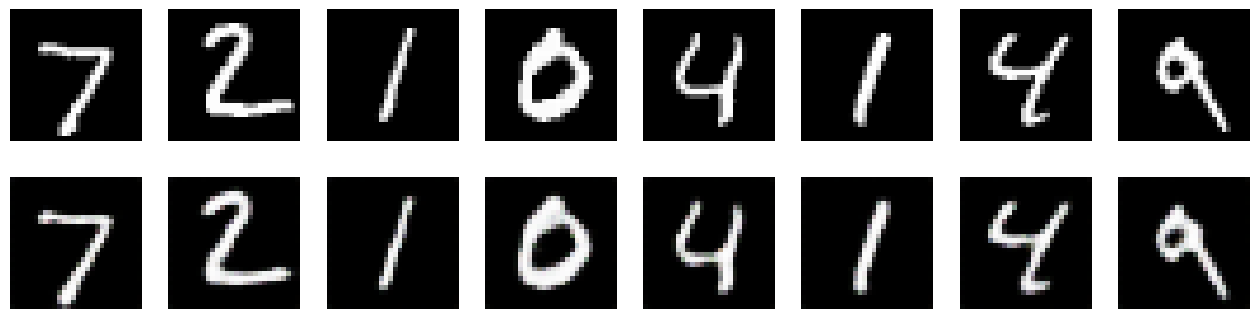

In [11]:
dataset_name = "MNIST"
cfg = datasets_config[dataset_name]
full_train = cfg["cls"](**cfg["args"])

test_set = cfg["cls"](**cfg["test_args"])
val_size = len(test_set) // 9
train_set, val_set = random_split(full_train, [len(full_train)-val_size, val_size])

train_loader = DataLoader(
    train_set, batch_size=cfg["batch_size"], 
    shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_set, batch_size=cfg["batch_size"],
    shuffle=False, num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=cfg["batch_size"],
    shuffle=False, num_workers=4
)

model = VQVAE(dataset_name)

best_model = train_vqvae(
    model, train_loader, val_loader,
    n_epochs=100, lr=2e-4, patience=15,
    save_path=f"best_{dataset_name.lower()}_vqvae.pth"
)

evaluate(best_model, test_loader)
visualize_reconstructions(best_model, test_loader, n=8)

### Driver code (CIFAR10)

Training Epoch 1: 100%|██████████| 382/382 [00:02<00:00, 169.27it/s]


Epoch 001 | Train: 0.1837 | Val: 0.1447


Training Epoch 2: 100%|██████████| 382/382 [00:01<00:00, 198.62it/s]


Epoch 002 | Train: 0.1768 | Val: 0.1937


Training Epoch 3: 100%|██████████| 382/382 [00:01<00:00, 197.42it/s]


Epoch 003 | Train: 0.1731 | Val: 0.1457


Training Epoch 4: 100%|██████████| 382/382 [00:01<00:00, 195.71it/s]


Epoch 004 | Train: 0.0920 | Val: 0.0703


Training Epoch 5: 100%|██████████| 382/382 [00:01<00:00, 198.42it/s]


Epoch 005 | Train: 0.0640 | Val: 0.0589


Training Epoch 6: 100%|██████████| 382/382 [00:01<00:00, 198.55it/s]


Epoch 006 | Train: 0.0600 | Val: 0.0595


Training Epoch 7: 100%|██████████| 382/382 [00:01<00:00, 198.11it/s]


Epoch 007 | Train: 0.0593 | Val: 0.0585


Training Epoch 8: 100%|██████████| 382/382 [00:01<00:00, 195.13it/s]


Epoch 008 | Train: 0.0588 | Val: 0.0589


Training Epoch 9: 100%|██████████| 382/382 [00:01<00:00, 193.89it/s]


Epoch 009 | Train: 0.0580 | Val: 0.0574


Training Epoch 10: 100%|██████████| 382/382 [00:01<00:00, 196.79it/s]


Epoch 010 | Train: 0.0580 | Val: 0.0593


Training Epoch 11: 100%|██████████| 382/382 [00:01<00:00, 193.82it/s]


Epoch 011 | Train: 0.0578 | Val: 0.0570


Training Epoch 12: 100%|██████████| 382/382 [00:01<00:00, 196.00it/s]


Epoch 012 | Train: 0.0582 | Val: 0.0581


Training Epoch 13: 100%|██████████| 382/382 [00:02<00:00, 184.97it/s]


Epoch 013 | Train: 0.0584 | Val: 0.0573


Training Epoch 14: 100%|██████████| 382/382 [00:01<00:00, 195.21it/s]


Epoch 014 | Train: 0.0591 | Val: 0.0602


Training Epoch 15: 100%|██████████| 382/382 [00:01<00:00, 199.12it/s]


Epoch 015 | Train: 0.0594 | Val: 0.0593


Training Epoch 16: 100%|██████████| 382/382 [00:01<00:00, 194.66it/s]


Epoch 016 | Train: 0.0601 | Val: 0.0597


Training Epoch 17: 100%|██████████| 382/382 [00:01<00:00, 196.92it/s]


Epoch 017 | Train: 0.0608 | Val: 0.0613


Training Epoch 18: 100%|██████████| 382/382 [00:01<00:00, 193.33it/s]


Epoch 018 | Train: 0.0616 | Val: 0.0619


Training Epoch 19: 100%|██████████| 382/382 [00:01<00:00, 191.12it/s]


Epoch 019 | Train: 0.0630 | Val: 0.0630


Training Epoch 20: 100%|██████████| 382/382 [00:02<00:00, 182.40it/s]


Epoch 020 | Train: 0.0651 | Val: 0.0665


Training Epoch 21: 100%|██████████| 382/382 [00:01<00:00, 196.09it/s]


Epoch 021 | Train: 0.0658 | Val: 0.0664


Training Epoch 22: 100%|██████████| 382/382 [00:01<00:00, 197.64it/s]


Epoch 022 | Train: 0.0659 | Val: 0.0655


Training Epoch 23: 100%|██████████| 382/382 [00:01<00:00, 198.83it/s]


Epoch 023 | Train: 0.0661 | Val: 0.0653


Training Epoch 24: 100%|██████████| 382/382 [00:01<00:00, 197.02it/s]


Epoch 024 | Train: 0.0665 | Val: 0.0652


Training Epoch 25: 100%|██████████| 382/382 [00:01<00:00, 198.73it/s]


Epoch 025 | Train: 0.0666 | Val: 0.0661


Training Epoch 26: 100%|██████████| 382/382 [00:01<00:00, 200.76it/s]


Epoch 026 | Train: 0.0671 | Val: 0.0661
Early stopping.
Test Loss: 0.0569


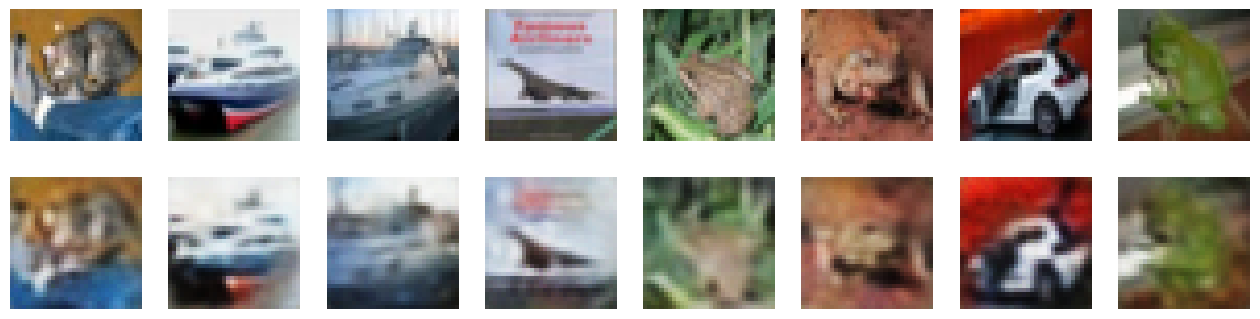

In [12]:
dataset_name = "CIFAR10"
cfg = datasets_config[dataset_name]
full_train = cfg["cls"](**cfg["args"])

test_set = cfg["cls"](**cfg["test_args"])
val_size = len(test_set) // 9
train_set, val_set = random_split(full_train, [len(full_train)-val_size, val_size])

train_loader = DataLoader(
    train_set, batch_size=cfg["batch_size"], 
    shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_set, batch_size=cfg["batch_size"],
    shuffle=False, num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=cfg["batch_size"],
    shuffle=False, num_workers=4
)

model = VQVAE(dataset_name)

best_model = train_vqvae(
    model, train_loader, val_loader,
    n_epochs=100, lr=2e-4, patience=15,
    save_path=f"best_{dataset_name.lower()}_vqvae.pth"
)

evaluate(best_model, test_loader)
visualize_reconstructions(best_model, test_loader, n=8)